In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import median
import os

In [2]:
aws_access_key = os.environ["AWS_ACCESS_KEY"]
aws_secret_key = os.environ["AWS_SECRET_KEY"]
aws_region = os.environ["AWS_REGION"]
warehouse_location = os.environ["WAREHOUSE_LOCATION"]
metastore_uri = os.environ["METASTORE_URI"]

spark = SparkSession.builder.appName("Warehouse")\
    .master("spark://spark-master:7077") \
    .config("spark.hadoop.fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider") \
    .config("spark.hadoop.fs.s3a.access.key", aws_access_key) \
    .config("spark.hadoop.fs.s3a.secret.key", aws_secret_key) \
    .config("spark.sql.catalogImplementation", "hive") \
    .config("spark.sql.warehouse.dir", warehouse_location) \
    .config("spark.sql.hive.metastore.uris", metastore_uri) \
    .config("hive.metastore.uris", metastore_uri) \
    .config("hive.metastore.warehouse.dir", warehouse_location) \
    .config("hive.hadoop.fs.s3a.access.key", aws_access_key) \
    .config("hive.hadoop.fs.s3a.secret.key", aws_secret_key) \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.driver.memory", "5G") \
    .config("spark.memory.offHeap.size","16g") \
    .config("spark.memory.offHeap.enabled", True) \
    .enableHiveSupport() \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [8]:
date_dimension = spark.sql("select * from dimensions.dates")
dimension_regions = spark.sql("select * from dimensions.states")

In [6]:
facts_year_id = spark.sql("select * from facts.year_id")
year_id = facts_year_id.join(date_dimension, facts_year_id.year == date_dimension.date, "inner").select(facts_year_id.year, "state", "count")
sales_per_year = year_id.groupBy("year").agg(F.sum("count").alias("number_of_sales")).orderBy("year")
sales_per_year = sales_per_year.toPandas()

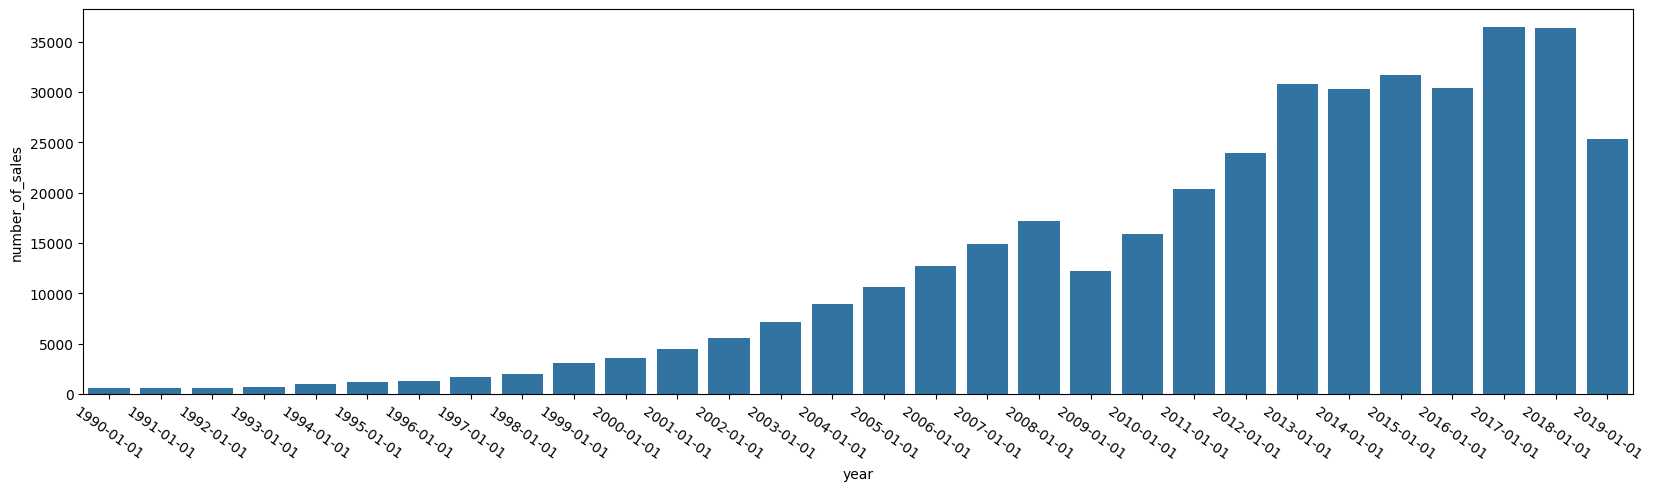

In [7]:
plt.figure(figsize=(20,5))
plt.xticks(rotation= -35)
sns.barplot(x="year", y="number_of_sales", data=sales_per_year, estimator=median)
plt.show()

In [13]:
facts_year_id_price = spark.sql("select * from facts.year_id_price")


year_id_price = facts_year_id_price\
.join(date_dimension, facts_year_id_price.year == date_dimension.date, "inner")\
.join(dimension_regions, facts_year_id_price.state == dimension_regions.state, "inner")\
.select(facts_year_id_price.year, facts_year_id_price.state, "price")\
.withColumn("value_of_sales", F.col("price").cast("int"))\
.orderBy(F.desc("value_of_sales"))

In [14]:
year_id_price = year_id_price.orderBy("year")
year_id_price.show(truncate=False)

+----------+-----+--------+--------------+
|year      |state|price   |value_of_sales|
+----------+-----+--------+--------------+
|1990-01-01|ak   |1500.0  |1500          |
|1990-01-01|ca   |768380.0|768380        |
|1990-01-01|al   |61500.0 |61500         |
|1990-01-01|fl   |420313.0|420313        |
|1990-01-01|ar   |40340.0 |40340         |
|1990-01-01|hi   |11750.0 |11750         |
|1990-01-01|ga   |2800.0  |2800          |
|1990-01-01|ms   |13300.0 |13300         |
|1990-01-01|de   |3500.0  |3500          |
|1990-01-01|nm   |39450.0 |39450         |
|1990-01-01|ks   |68045.0 |68045         |
|1990-01-01|nv   |29200.0 |29200         |
|1990-01-01|az   |103839.0|103839        |
|1990-01-01|wy   |18000.0 |18000         |
|1990-01-01|la   |23500.0 |23500         |
|1990-01-01|il   |132794.0|132794        |
|1990-01-01|mt   |42750.0 |42750         |
|1990-01-01|co   |207318.0|207318        |
|1990-01-01|sd   |5990.0  |5990          |
|1990-01-01|in   |55350.0 |55350         |
+----------

In [15]:
year_id_price_pd = year_id_price.toPandas()

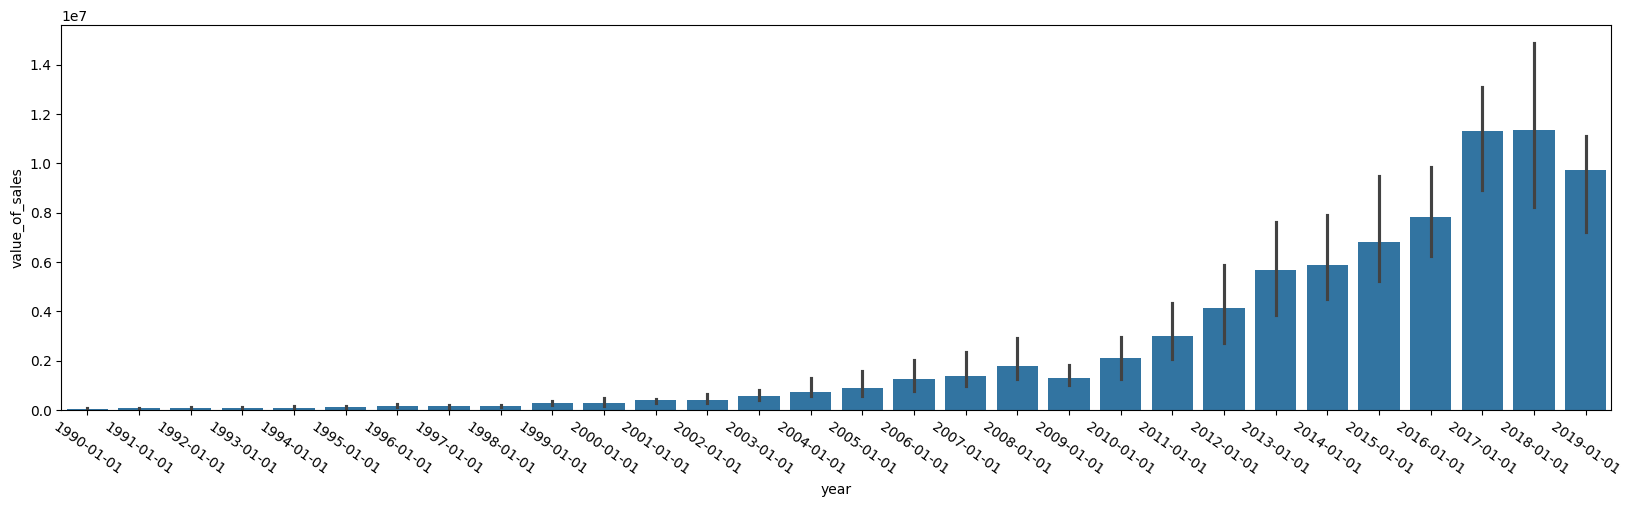

In [16]:
# prices per year
plt.figure(figsize=(20,5))
plt.xticks(rotation= -35)
sns.barplot(x="year", y="value_of_sales", data=year_id_price_pd, estimator=median)
plt.show()

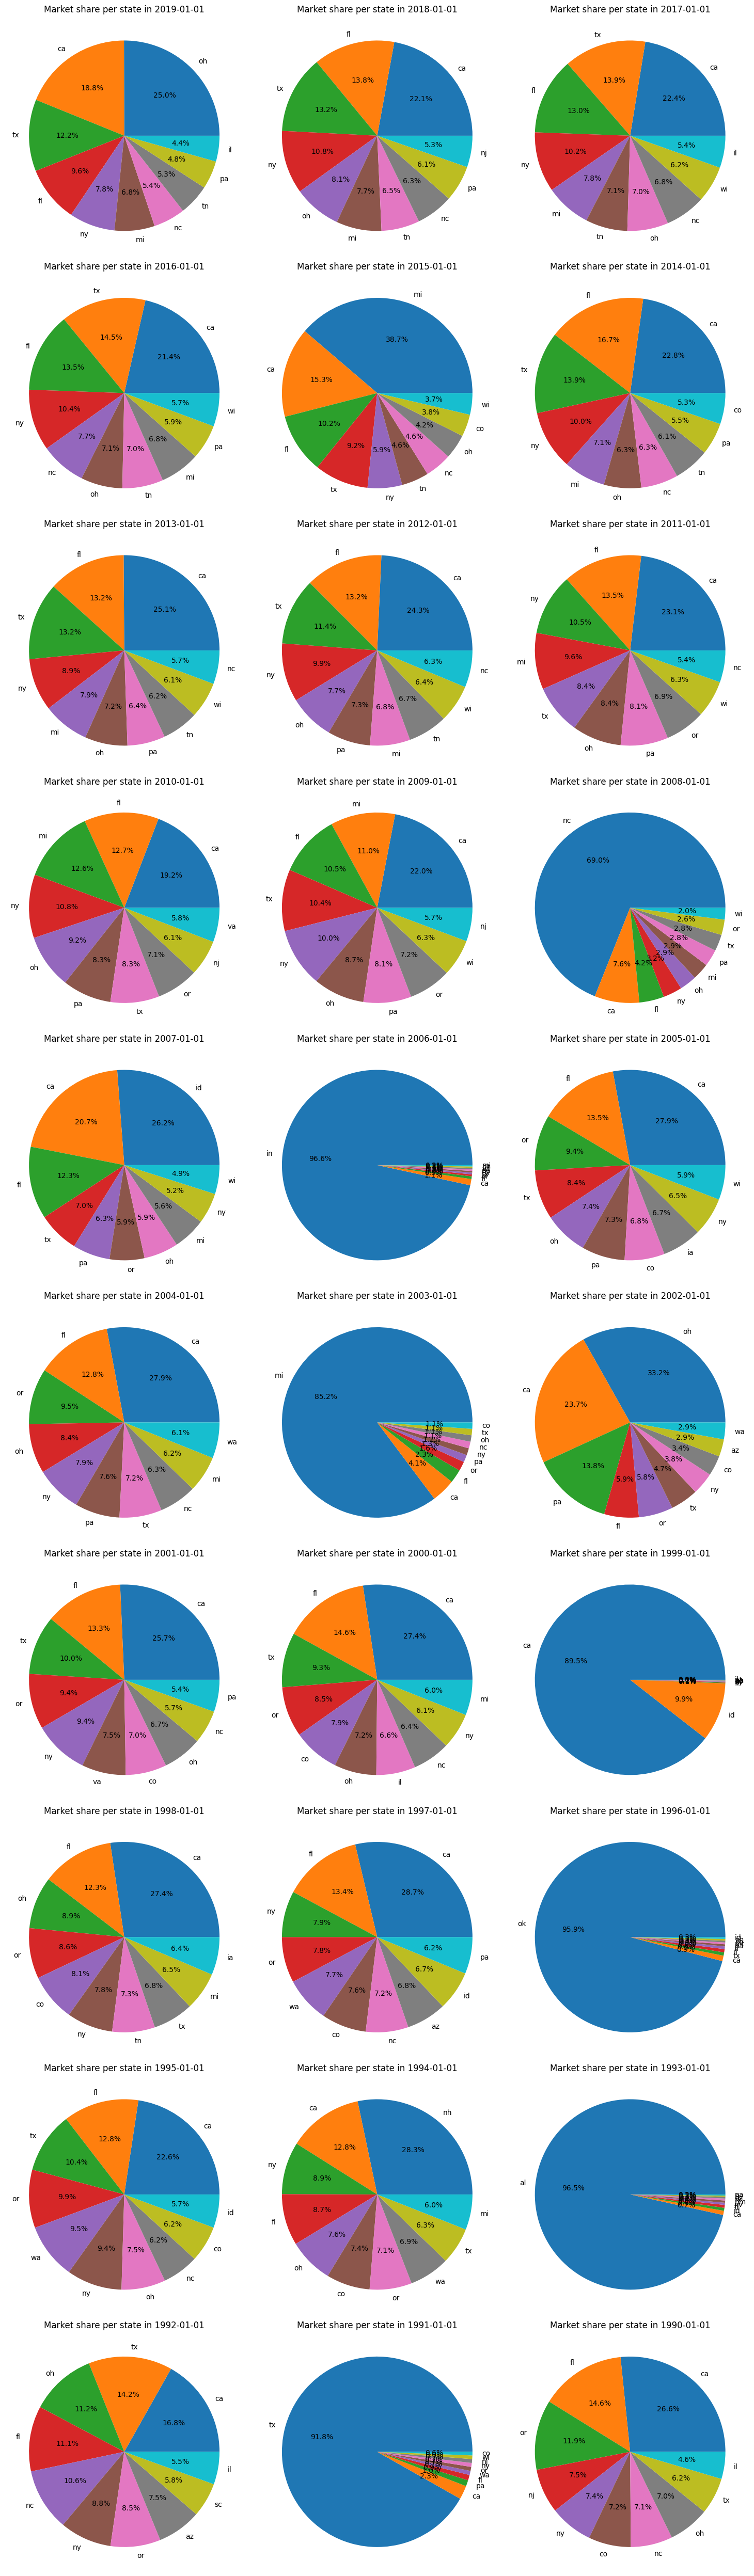

In [20]:
# Sort the dataframe by year and value_of_sales in descending order
year_id_price_pd = year_id_price_pd.sort_values(by=['year', 'value_of_sales'], ascending=False)

# Group the dataframe by year and select the top 10 regions for each year
year_id_price_pd = year_id_price_pd.groupby('year').head(60)

# Calculate the number of rows and columns for the grid
num_years = len(year_id_price_pd['year'].unique())
num_cols = 3
num_rows = (num_years + num_cols - 1) // num_cols

# Create the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

# Iterate over the years and create the pie charts
for i, year in enumerate(year_id_price_pd['year'].unique()):
    data = year_id_price_pd[year_id_price_pd['year'] == year]
    ax = axes[i // num_cols, i % num_cols]
    ax.pie(data['value_of_sales'], labels=data['state'], autopct='%1.1f%%')
    ax.set_title('Market share per state in ' + str(year))

# Remove any unused subplots
for j in range(num_years, num_rows * num_cols):
    fig.delaxes(axes[j // num_cols, j % num_cols])

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()
    
    
    

In [ ]:
spark.stop()